In [1]:
import os
from tqdm import tqdm

import numpy as np
import pickle
import pandas as pd
import re
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import roc_curve, auc, roc_auc_score
from draw_utils import count_gene_kind, count_pfam, get_antiSMASH_class, class_dict, class_dict_2, class_to_tensor

import math

CURRENT_DIR=os.getcwd()
print(CURRENT_DIR)
save_dir = os.path.join(CURRENT_DIR, "visualization", "file_MAC_multihead")



/data5_large/home/kechenlu/natural_product/visualization


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams.update({
    'font.size': 8,
    'font.family': 'sans-serif',
    #'font.sans-serif': ['Arial'],  # Substitute with 'Helvetica' or system default
    'axes.linewidth': .75,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    #'xtick.direction': 'in',
    #'ytick.direction': 'in',
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'lines.linewidth': .75,
    'savefig.dpi': 600,
    'pdf.fonttype': 42,  # For editable text in Illustrator
    'ps.fonttype': 42,
})
plt.rcParams['figure.dpi'] = 600

CURRENT_DIR=os.getcwd()
print(CURRENT_DIR)
save_dir = os.path.join(CURRENT_DIR, "supporting_figs")

/data5_large/home/kechenlu/natural_product/visualization


## NPatlas analysis

### (1)Prepare NPAtalas SMILES list

In [3]:
# NP atlas candidate part 1
NPatlas = pd.read_csv("../data/natural_product/NPAtlas_download_2024_09.tsv", sep = "\t")
NPatlas_cluster = NPatlas.groupby('compound_cluster_id').sample(n=1, random_state=42).reset_index(drop=True)
NP_list = NPatlas_cluster["compound_smiles"].tolist() # 10508 SMILES


In [4]:
print(len(NPatlas))
print(len(NP_list))

36454
10508


In [5]:
# # NP atlas candidate part 2: SMILES from MAP test data
MAP_testdata = pd.read_pickle("../ckpt/BGC_MAP/test_MAP_metadata_42.pkl")
positive_MAP_test = MAP_testdata[MAP_testdata["is_product"] == 1]
positive_MAP_test_sample = positive_MAP_test.groupby('BGC_number').sample(n=1, random_state=42).reset_index(drop=True)
MAP_test_smiles = positive_MAP_test_sample["product"].to_list() # 333 SMILES


In [6]:
# merosterol, dapalide A-C, lyngbyapeptin A
added_smiles = ["COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl)[C@]1(O)C[C@@H](O)[C@]2(C)C(=Cc4c5c(cc(Cl)c42)OCO5)[C@@]1(C)[C@H]3O", 
                r"C/C=C1\NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@@H]([C@@H](C)CC)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](NC(=O)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H]2CCCN2C(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](NC(=O)CCCCCCC)[C@@H](C)O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](C)O)[C@@H](C)O)C(C)C)[C@@H](C)CC)[C@@H](C)OC(=O)[C@H](C(C)C)NC1=O", 
                "CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1c1nccs1)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc1ccc(OC)cc1)N(C)C(=O)/C=C(\C)OC"]
NP_list.extend(MAP_test_smiles)
print(len(NP_list))
NP_list.extend(added_smiles)
print(len(NP_list))
NP_list = list(set(NP_list))
print(len(NP_list))

# pickle.dump(NP_list, open('../data/natural_product/NP_cluster_42_MAP_test_Ding4.pkl', 'wb'))

10841
10844
10829


In [7]:
BGC_product_mapping = positive_MAP_test_sample.set_index('BGC_number')['product'].to_dict()
BGC_product_mapping["19"] = r"C/C=C1\NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@@H]([C@@H](C)CC)NC(=O)[C@@H](CC(C)C)NC(=O)[C@H](NC(=O)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H]2CCCN2C(=O)[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](NC(=O)CCCCCCC)[C@@H](C)O[C@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](C)O)[C@@H](C)O)C(C)C)[C@@H](C)CC)[C@@H](C)OC(=O)[C@H](C(C)C)NC1=O"
BGC_product_mapping["37"] = "CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1c1nccs1)N(C)C(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](Cc1ccc(OC)cc1)N(C)C(=O)/C=C(\C)OC"
BGC_product_mapping["49"] = "COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl)[C@]1(O)C[C@@H](O)[C@]2(C)C(=Cc4c5c(cc(Cl)c42)OCO5)[C@@]1(C)[C@H]3O"
pickle.dump(BGC_product_mapping, open('../data/natural_product/BGC_product_mapping_for_npatlas.pkl', 'wb'))

### (2) Analyze Data

In [10]:
from sklearn.manifold import TSNE
BGC_product_mapping = pickle.load(open('../data/natural_product/BGC_product_mapping_for_npatlas.pkl', 'rb'))
product_ECFP = pickle.load(open("../data/natural_product/NPatlas_ECFP.pkl", "rb"))

In [11]:
atlas_result_1 = pd.read_csv("../output/MAP_table2_NPatlas.csv") # Table2 BGC
atlas_result_2 = pd.read_csv("../output/MAP_BGC#123_NPatlas.csv") # BGC#1 (19) 2 (37) 3 (49) 
atlas_result_3 = pd.read_csv("../output/MAP_table2_extra_NPatlas.csv") # Additional 2 BGC
atlas_result = pd.concat([atlas_result_1, atlas_result_2, atlas_result_3], ignore_index=True)
atlas_result

Unnamed: 0                                           Gbk_file  \
0                0  /data5_large/home/kechenlu/natural_product/dat...   
1                1  /data5_large/home/kechenlu/natural_product/dat...   
2                2  /data5_large/home/kechenlu/natural_product/dat...   
3                3  /data5_large/home/kechenlu/natural_product/dat...   
4                4  /data5_large/home/kechenlu/natural_product/dat...   
...            ...                                                ...   
129923       21647  /data5_large/home/kechenlu/natural_product/dat...   
129924       21648  /data5_large/home/kechenlu/natural_product/dat...   
129925       21649  /data5_large/home/kechenlu/natural_product/dat...   
129926       21650  /data5_large/home/kechenlu/natural_product/dat...   
129927       21651  /data5_large/home/kechenlu/natural_product/dat...   

                                      Prospective Product  Probability  
0       CCC[C@H]1C[C@@H]([C@]2(O1)C3=CC(=C(C(=C3C(=O)O...     0.031265  
1       CCC(C)CC/C=C\C=C\C(=O)NCC(=O)NCC(=O)N[C@@H](C(...     0.126453  
2       CC1=C2C(=O)C[C@@]2(C)[C@@H]2[C@@H](O)[C@@H]3C(...     0.108951  
3                 CC[C@H](C)[C@H](CO)NC(=O)/C(=C/C=C/C)/C     0.187942  
4                                   C1=C(C1=O)CCCCCC(=O)O     0.228477  
...                                                   ...          ...  
129923  C[C@H]1C[C@@H]([C@@H]([C@]2(O1)C3=C([C@H]4[C@@...     0.350992  
129924  C[C@@H]1[C@H](C[C@]2([C@@]1([C@@H]3CC(C=C3[C@H...     0.639022  
129925  CC(CC(C)C1=NC(CS1)(C)C(=O)O)CC(C)C(=O)/C=C(/C2...     0.018321  
129926                   CCCCCCCC1=C(C(=O)C2=CC=CC=C2N1)O     0.069747  
129927  C1=CC(=CC(=NO)C1O)CO.C1=CC(=CC(=NO)C1O)C=O.C1=...     0.049105  

[129928 rows x 4 columns]

In [11]:
result_df = atlas_result.copy()

result_df['ranking'] = 0

unique_gbk_files = result_df['Gbk_file'].unique()

print(f"\nFind {len(unique_gbk_files)} unique gbk_file")

for gbk_file in unique_gbk_files:
    group_df = result_df[result_df['Gbk_file'] == gbk_file].copy()
    
    if len(group_df) > 1:
        print(f"\nProcessing {gbk_file}:")
        print(f"Candidate Number: {len(group_df)}")
        
        sorted_group = group_df.sort_values('Probability', ascending=False)
        
        ranks = range(1, len(sorted_group) + 1)
        
        for idx, rank in zip(sorted_group.index, ranks):
            result_df.at[idx, 'ranking'] = rank
            
    else:
        idx = group_df.index[0]
        result_df.at[idx, 'ranking'] = 1
        print(f"\n {gbk_file}: Only one record")

result_df = result_df.drop(columns = ["Unnamed: 0"])
result_df["Gbk_file"] = result_df["Gbk_file"].apply(lambda x:os.path.splitext(os.path.basename(x))[0])
result_df["ECFP"] = result_df["Prospective Product"].map(product_ECFP)
result_df


Find 12 unique gbk_file

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/test_table2/BGC0001007.gbk:
Candidate Number: 10826

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/test_table2/BGC0001790.gbk:
Candidate Number: 10826

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/test_table2/BGC0000693.gbk:
Candidate Number: 10826

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/test_table2/BGC0002786.gbk:
Candidate Number: 10826

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/test_table2/BGC0000448.gbk:
Candidate Number: 10826

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/test_table2/BGC0002209.gbk:
Candidate Number: 10826

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/DingBGC_test/37.gbk:
Candidate Number: 10830

Processing /data5_large/home/kechenlu/natural_product/data/natural_product/DingBGC_te

Gbk_file                                Prospective Product  \
0       BGC0001007  CCC[C@H]1C[C@@H]([C@]2(O1)C3=CC(=C(C(=C3C(=O)O...   
1       BGC0001007  CCC(C)CC/C=C\C=C\C(=O)NCC(=O)NCC(=O)N[C@@H](C(...   
2       BGC0001007  CC1=C2C(=O)C[C@@]2(C)[C@@H]2[C@@H](O)[C@@H]3C(...   
3       BGC0001007            CC[C@H](C)[C@H](CO)NC(=O)/C(=C/C=C/C)/C   
4       BGC0001007                              C1=C(C1=O)CCCCCC(=O)O   
...            ...                                                ...   
129923  BGC0000676  C[C@H]1C[C@@H]([C@@H]([C@]2(O1)C3=C([C@H]4[C@@...   
129924  BGC0000676  C[C@@H]1[C@H](C[C@]2([C@@]1([C@@H]3CC(C=C3[C@H...   
129925  BGC0000676  CC(CC(C)C1=NC(CS1)(C)C(=O)O)CC(C)C(=O)/C=C(/C2...   
129926  BGC0000676                   CCCCCCCC1=C(C(=O)C2=CC=CC=C2N1)O   
129927  BGC0000676  C1=CC(=CC(=NO)C1O)CO.C1=CC(=CC(=NO)C1O)C=O.C1=...   

        Probability  ranking  \
0          0.031265     8459   
1          0.126453     5292   
2          0.108951     5648   
3          0.187942     4402   
4          0.228477     4030   
...             ...      ...   
129923     0.350992     4458   
129924     0.639022      867   
129925     0.018321     9894   
129926     0.069747     8355   
129927     0.049105     8883   

                                                     ECFP  
0       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1       [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, ...  
2       [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...  
3       [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, ...  
4       [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...  
...                                                   ...  
129923  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
129924  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...  
129925  [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...  
129926  [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, ...  
129927  [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...  

[129928 rows x 5 columns]

In [12]:
def get_ranking(df, gbk_file, prospective_product):
    mask = (df['Gbk_file'] == gbk_file) & (df['Prospective Product'] == prospective_product)
    matching_rows = df[mask]
    
    if len(matching_rows) == 1:
        return matching_rows['ranking'].iloc[0]
    elif len(matching_rows) == 0:
        print(f"警告：未找到匹配的记录 - Gbk_file: {gbk_file}, Product: {prospective_product}")
        return None
    else:
        print(f"警告：找到多个匹配记录 - Gbk_file: {gbk_file}, Product: {prospective_product}")
        return matching_rows['ranking'].tolist()

test_BGC = [ "BGC0001007", "BGC0000448", "BGC0000693", "BGC0001790", "BGC0002209", "BGC0000045", "BGC0000676", "19" ,"37", "49"]

for gbk_file in test_BGC:
    prospective_product = BGC_product_mapping[gbk_file]
    print(gbk_file, get_ranking(result_df, gbk_file, prospective_product))
    

BGC0001007 240
BGC0000448 3072
BGC0000693 117
BGC0001790 216
BGC0002209 8730
BGC0000045 1168
BGC0000676 313
19 1889
37 43
49 3542


In [13]:
def knn_average_by_index(array1, array2, k, query_index):
    if k==0:
        return np.mean(array2[query_index])
    query_point = array1[query_index]
    distances = np.linalg.norm(array1 - query_point, axis=1) 
    distances[query_index] = np.inf
    nearest_indices = np.argpartition(distances, k)[:k]
    return np.mean(array2[nearest_indices])

In [ ]:
k_values = np.logspace(0, 4, num=50, dtype=int)  
k_values = np.unique(k_values)  
k_values = np.insert(k_values, 0, 0)

In [44]:
from collections import defaultdict

result = defaultdict(list)
BGC_number_list = [ "BGC0001007", "BGC0000693", "BGC0001790",  "BGC0000045", "BGC0000676", "19" ,"37"]
for BGC_number in tqdm(BGC_number_list, desc = "BGC_number"):
    result_BGC = result_df[result_df["Gbk_file"] == BGC_number]
    array1 = np.stack(result_BGC["ECFP"].to_numpy())
    #array2 = result_BGC["Probability"].to_numpy().reshape(-1,1)
    array2 = result_BGC["ranking"].to_numpy().reshape(-1,1)
    product_list = result_BGC["Prospective Product"].tolist()
    target_index = product_list.index(BGC_product_mapping[BGC_number])


    for k in tqdm(range(0, 1000, 5), desc = "k"):
        result[BGC_number].append((k, knn_average_by_index(array1, array2, k, target_index)))

BGC_number: 100%|██████████| 7/7 [01:43<00:00, 14.74s/it]


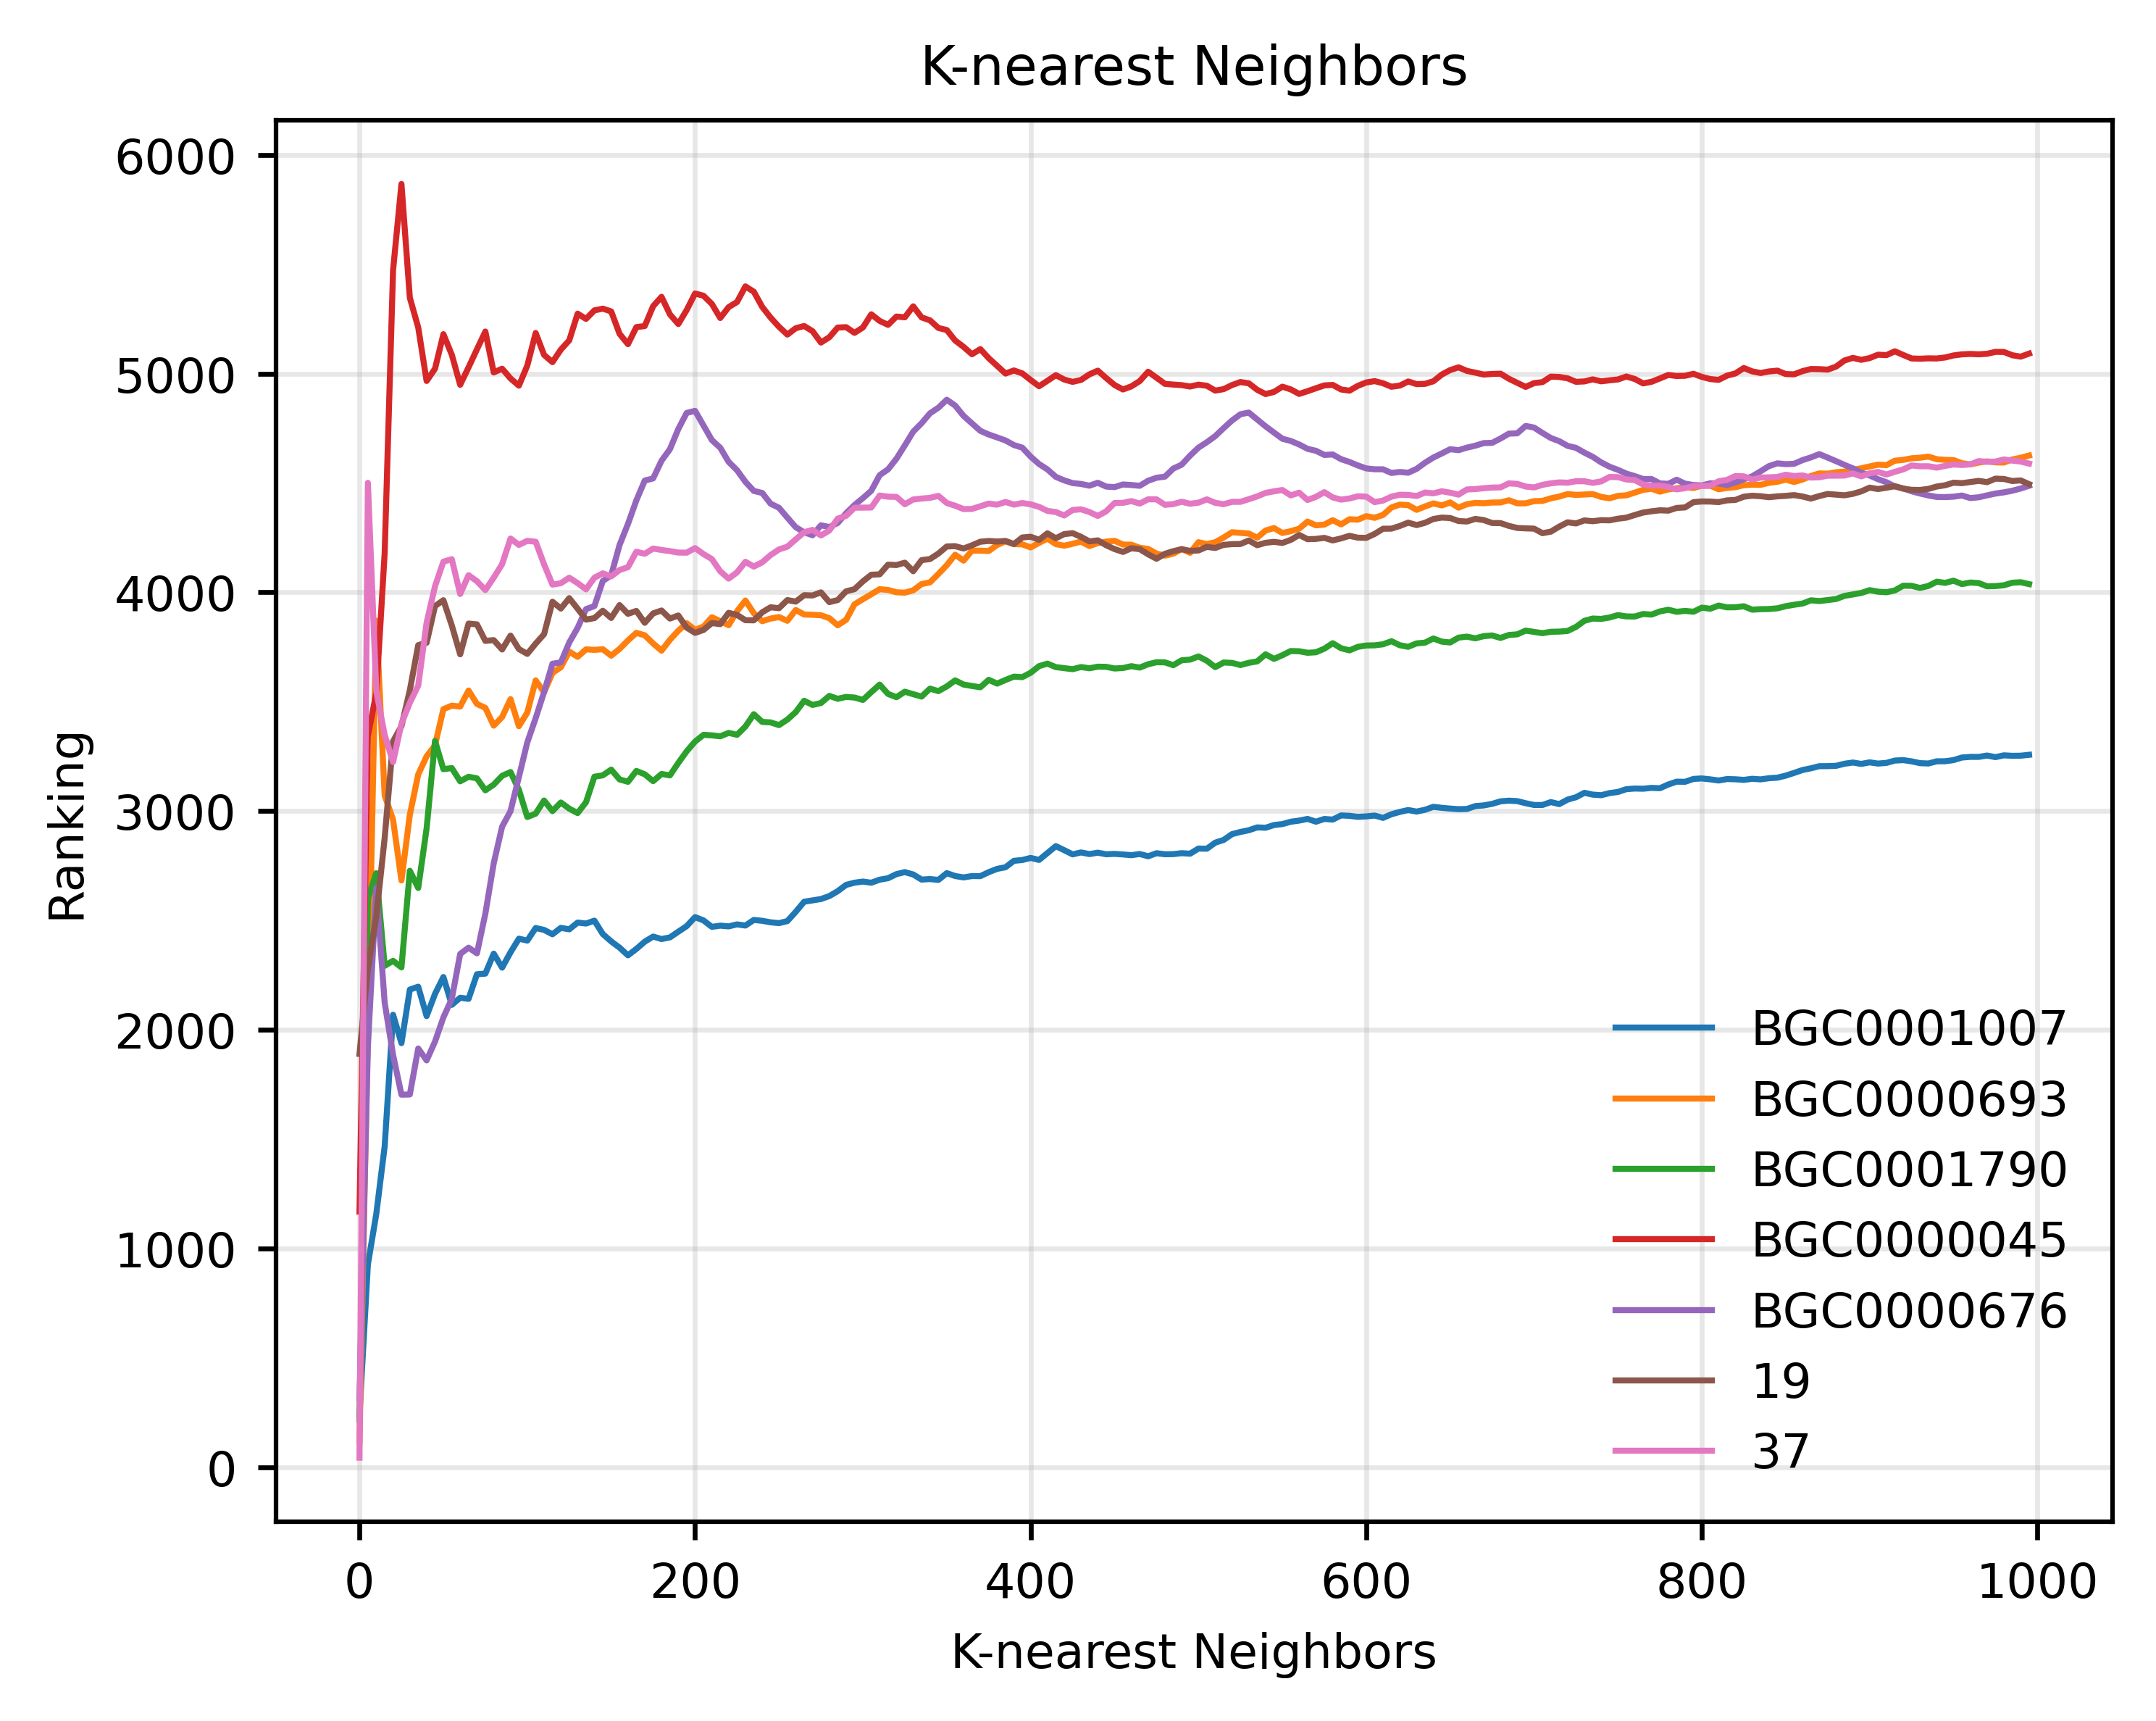

In [45]:
plt.figure(figsize=(5, 4))

for label, points in result.items():
    x_coords, y_coords = zip(*points)
    
    plt.plot(x_coords, y_coords, linestyle='-', linewidth=1, 
             label=label, markersize=6)

plt.title('K-nearest Neighbors', fontsize=9)
plt.xlabel('K-nearest Neighbors', fontsize=8)
plt.ylabel('Ranking', fontsize=8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

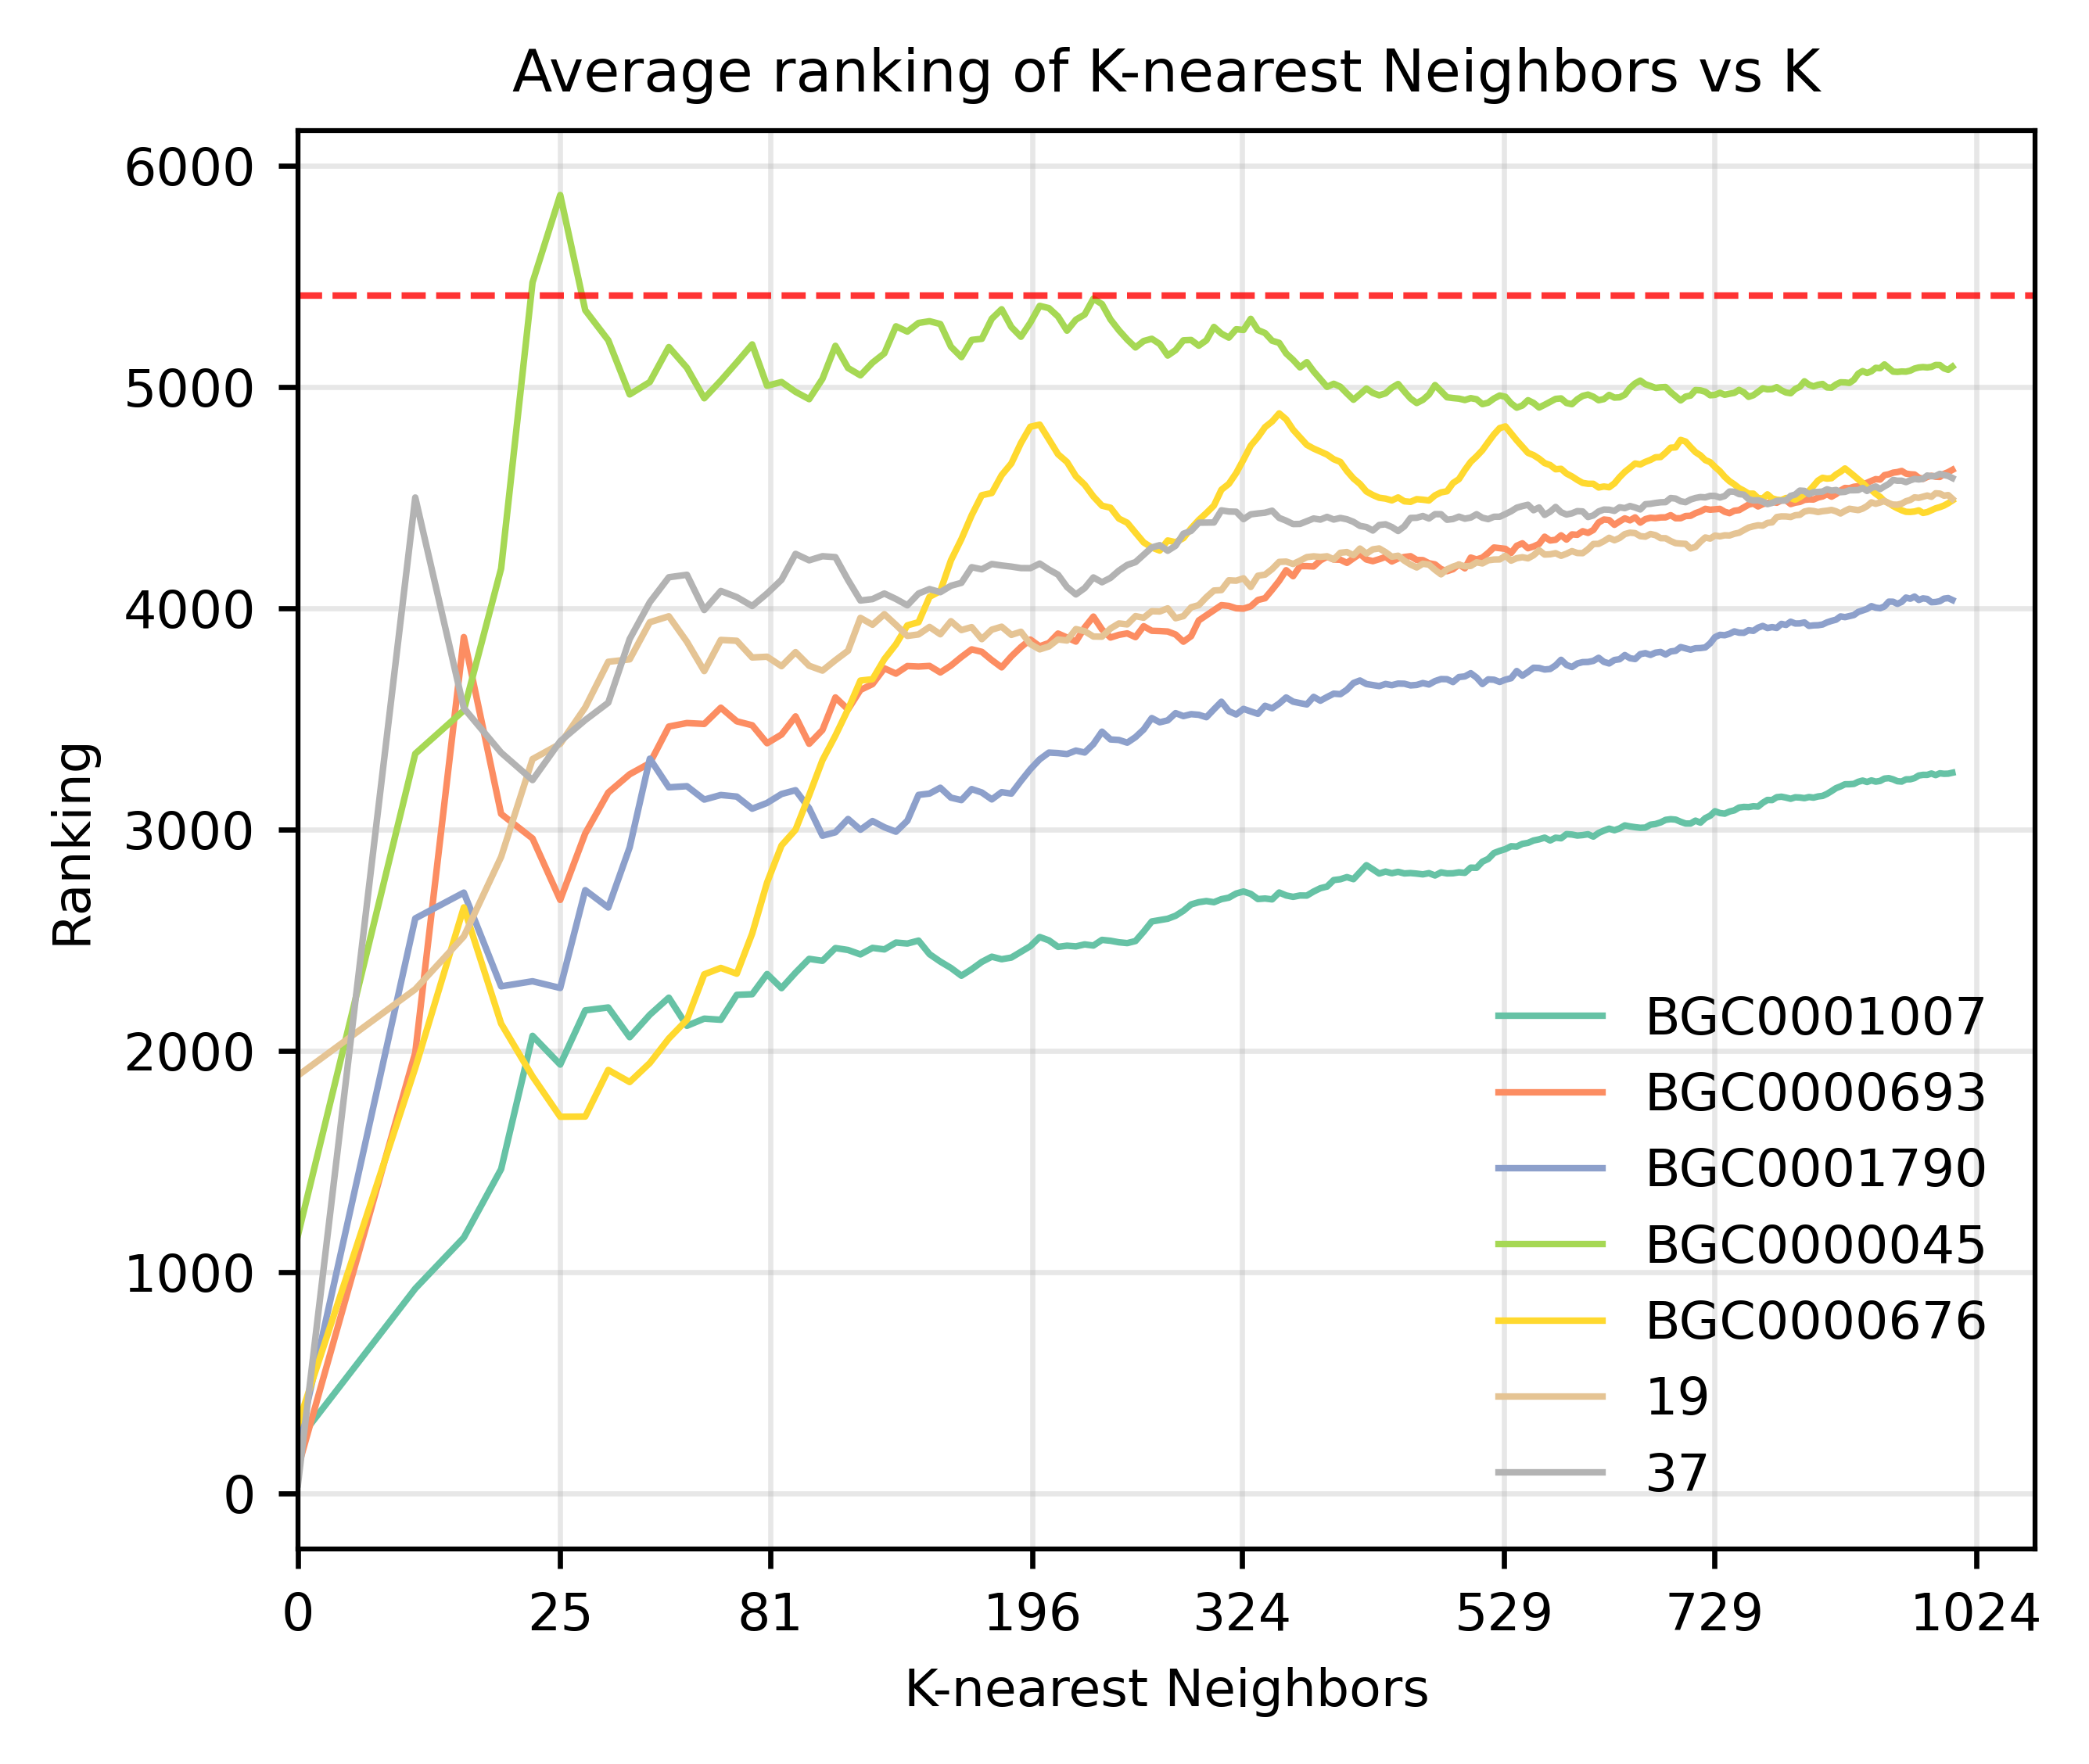

In [ ]:
import matplotlib.cm as cm
def sqrt_transform(x):
    return np.sqrt(x)

def square_transform(x):
    return x**2

colors = cm.Set2(np.linspace(0, 1, len(result)))
plt.figure(figsize=(4.5, 3.8))

for i, (label, points) in enumerate(result.items()):
    x_coords, y_coords = zip(*points)

    plt.plot(x_coords, y_coords, linestyle='-', color=colors[i], linewidth=1,
             label=label, markersize=6)


plt.xscale('function', functions=(sqrt_transform, square_transform))

sqrt_min = np.sqrt(min(min(x for x, y in points) for points in result.values()))
sqrt_max = np.sqrt(max(max(x for x, y in points) for points in result.values()))
sqrt_ticks = np.round(np.linspace(sqrt_min, sqrt_max, 8))

original_ticks = [t**2 for t in sqrt_ticks]
plt.xticks(original_ticks)

plt.axhline(y=5413, color='red', linestyle='--', linewidth=1, alpha=0.8)


plt.title('Average ranking of K-nearest Neighbors vs K', fontsize=9)
plt.xlabel('K-nearest Neighbors', fontsize=8)
plt.ylabel('Ranking', fontsize=8)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join("..", "visualization", "figures", "KNN_ranking_NPatlas.pdf"), format='pdf')
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)

ECFP_mapping = result_df.set_index("Prospective Product")["ECFP"].to_dict()
ECFP_array= np.array(list(ECFP_mapping.values()))
smiles_list = list(ECFP_mapping.keys())
ECFP_2d = tsne.fit_transform(ECFP_array)

ECFP_2d_mapping = {}
for i, smiles in enumerate(smiles_list):
    ECFP_2d_mapping[smiles] = ECFP_2d[i]

pickle.dump(ECFP_2d_mapping, open("../data/natural_product/NPatlas_ECFP_2d_TSNE_50_1000.pkl", "wb"))

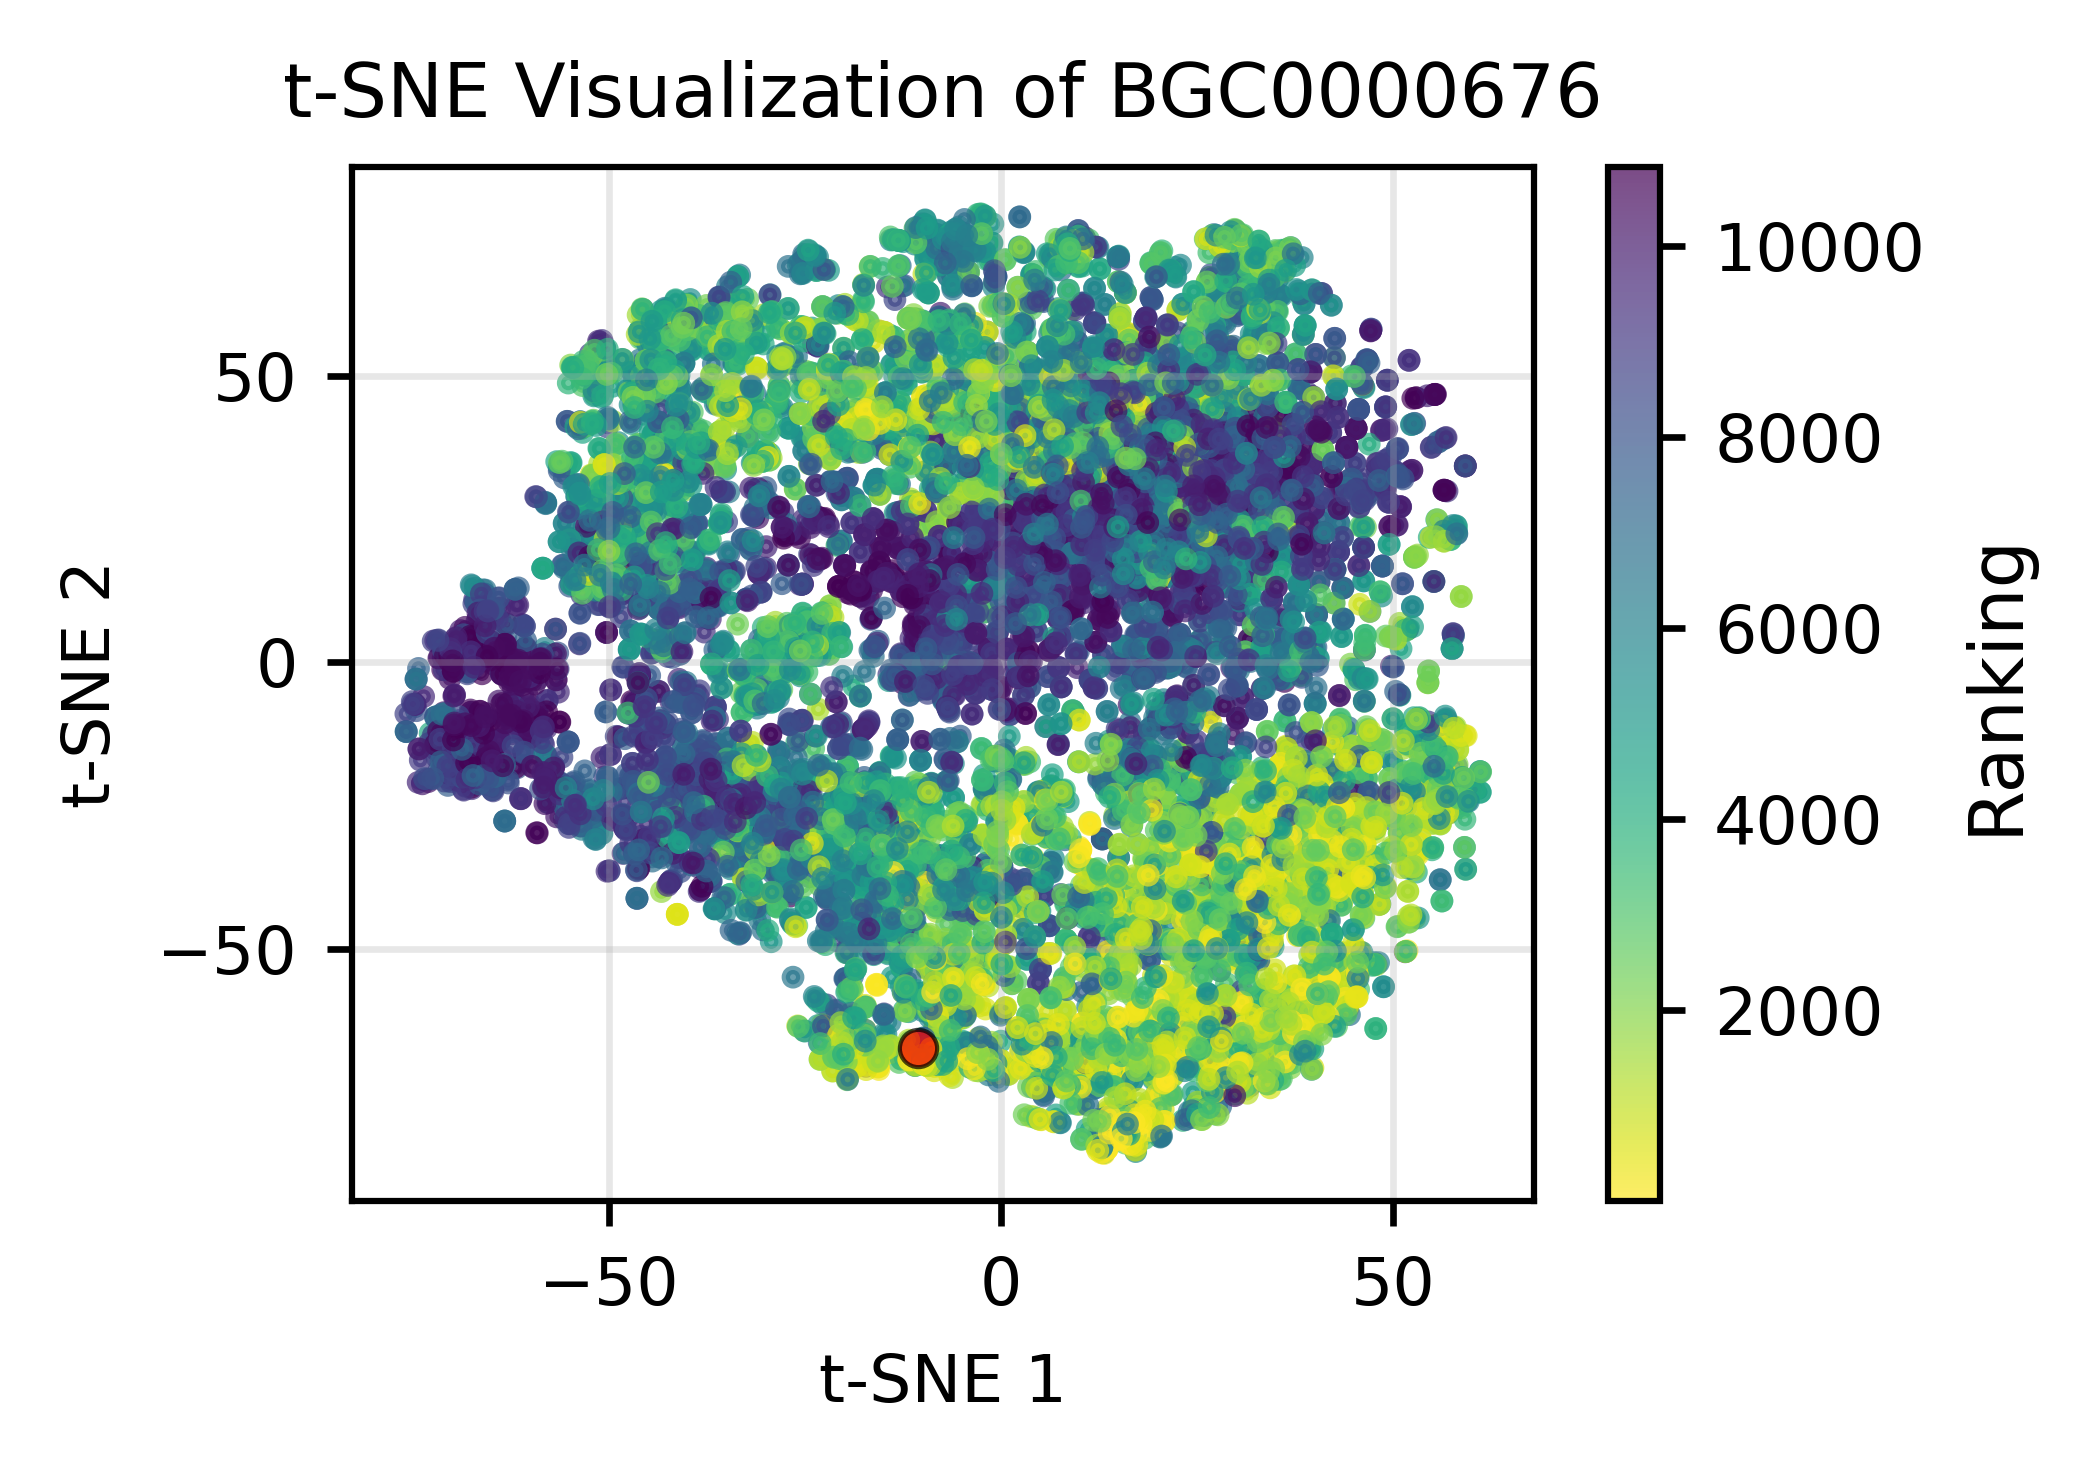

In [125]:
def tsne_pipeline(BGC_product_mapping: dict, ECFP_2d_mapping:dict, BGC_number:str, result_df:pd.DataFrame):
    result_BGC = result_df[result_df["Gbk_file"] == BGC_number]
    product_list = result_BGC["Prospective Product"].tolist()
    target_index = product_list.index(BGC_product_mapping[BGC_number])
    rank = np.array(result_BGC["ranking"].tolist())
    ECFP_2d = np.array([ECFP_2d_mapping[smiles] for smiles in product_list if smiles in ECFP_2d_mapping])
    plt.figure(figsize=(3.5, 2.5))
    scatter = plt.scatter(ECFP_2d[:, 0], ECFP_2d[:, 1], c=rank, cmap='viridis_r', s=3, alpha=0.7)

    plt.scatter(ECFP_2d[target_index, 0], ECFP_2d[target_index, 1], 
                    c='red', s=20, alpha=0.7, edgecolors='black', linewidth=0.5) 

    plt.colorbar(scatter, label='Ranking')
    plt.xlabel('t-SNE 1', size = 8)
    plt.ylabel('t-SNE 2', size = 8)
    plt.title(f't-SNE Visualization of {BGC_number}', size = 9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join("..", "visualization", "supporting_figs", f"tsne_npatlas_{BGC_number}.svg"), format='svg')
    plt.show()

tsne_pipeline(BGC_product_mapping, ECFP_2d_mapping, BGC_number = "BGC0000676", result_df = result_df)

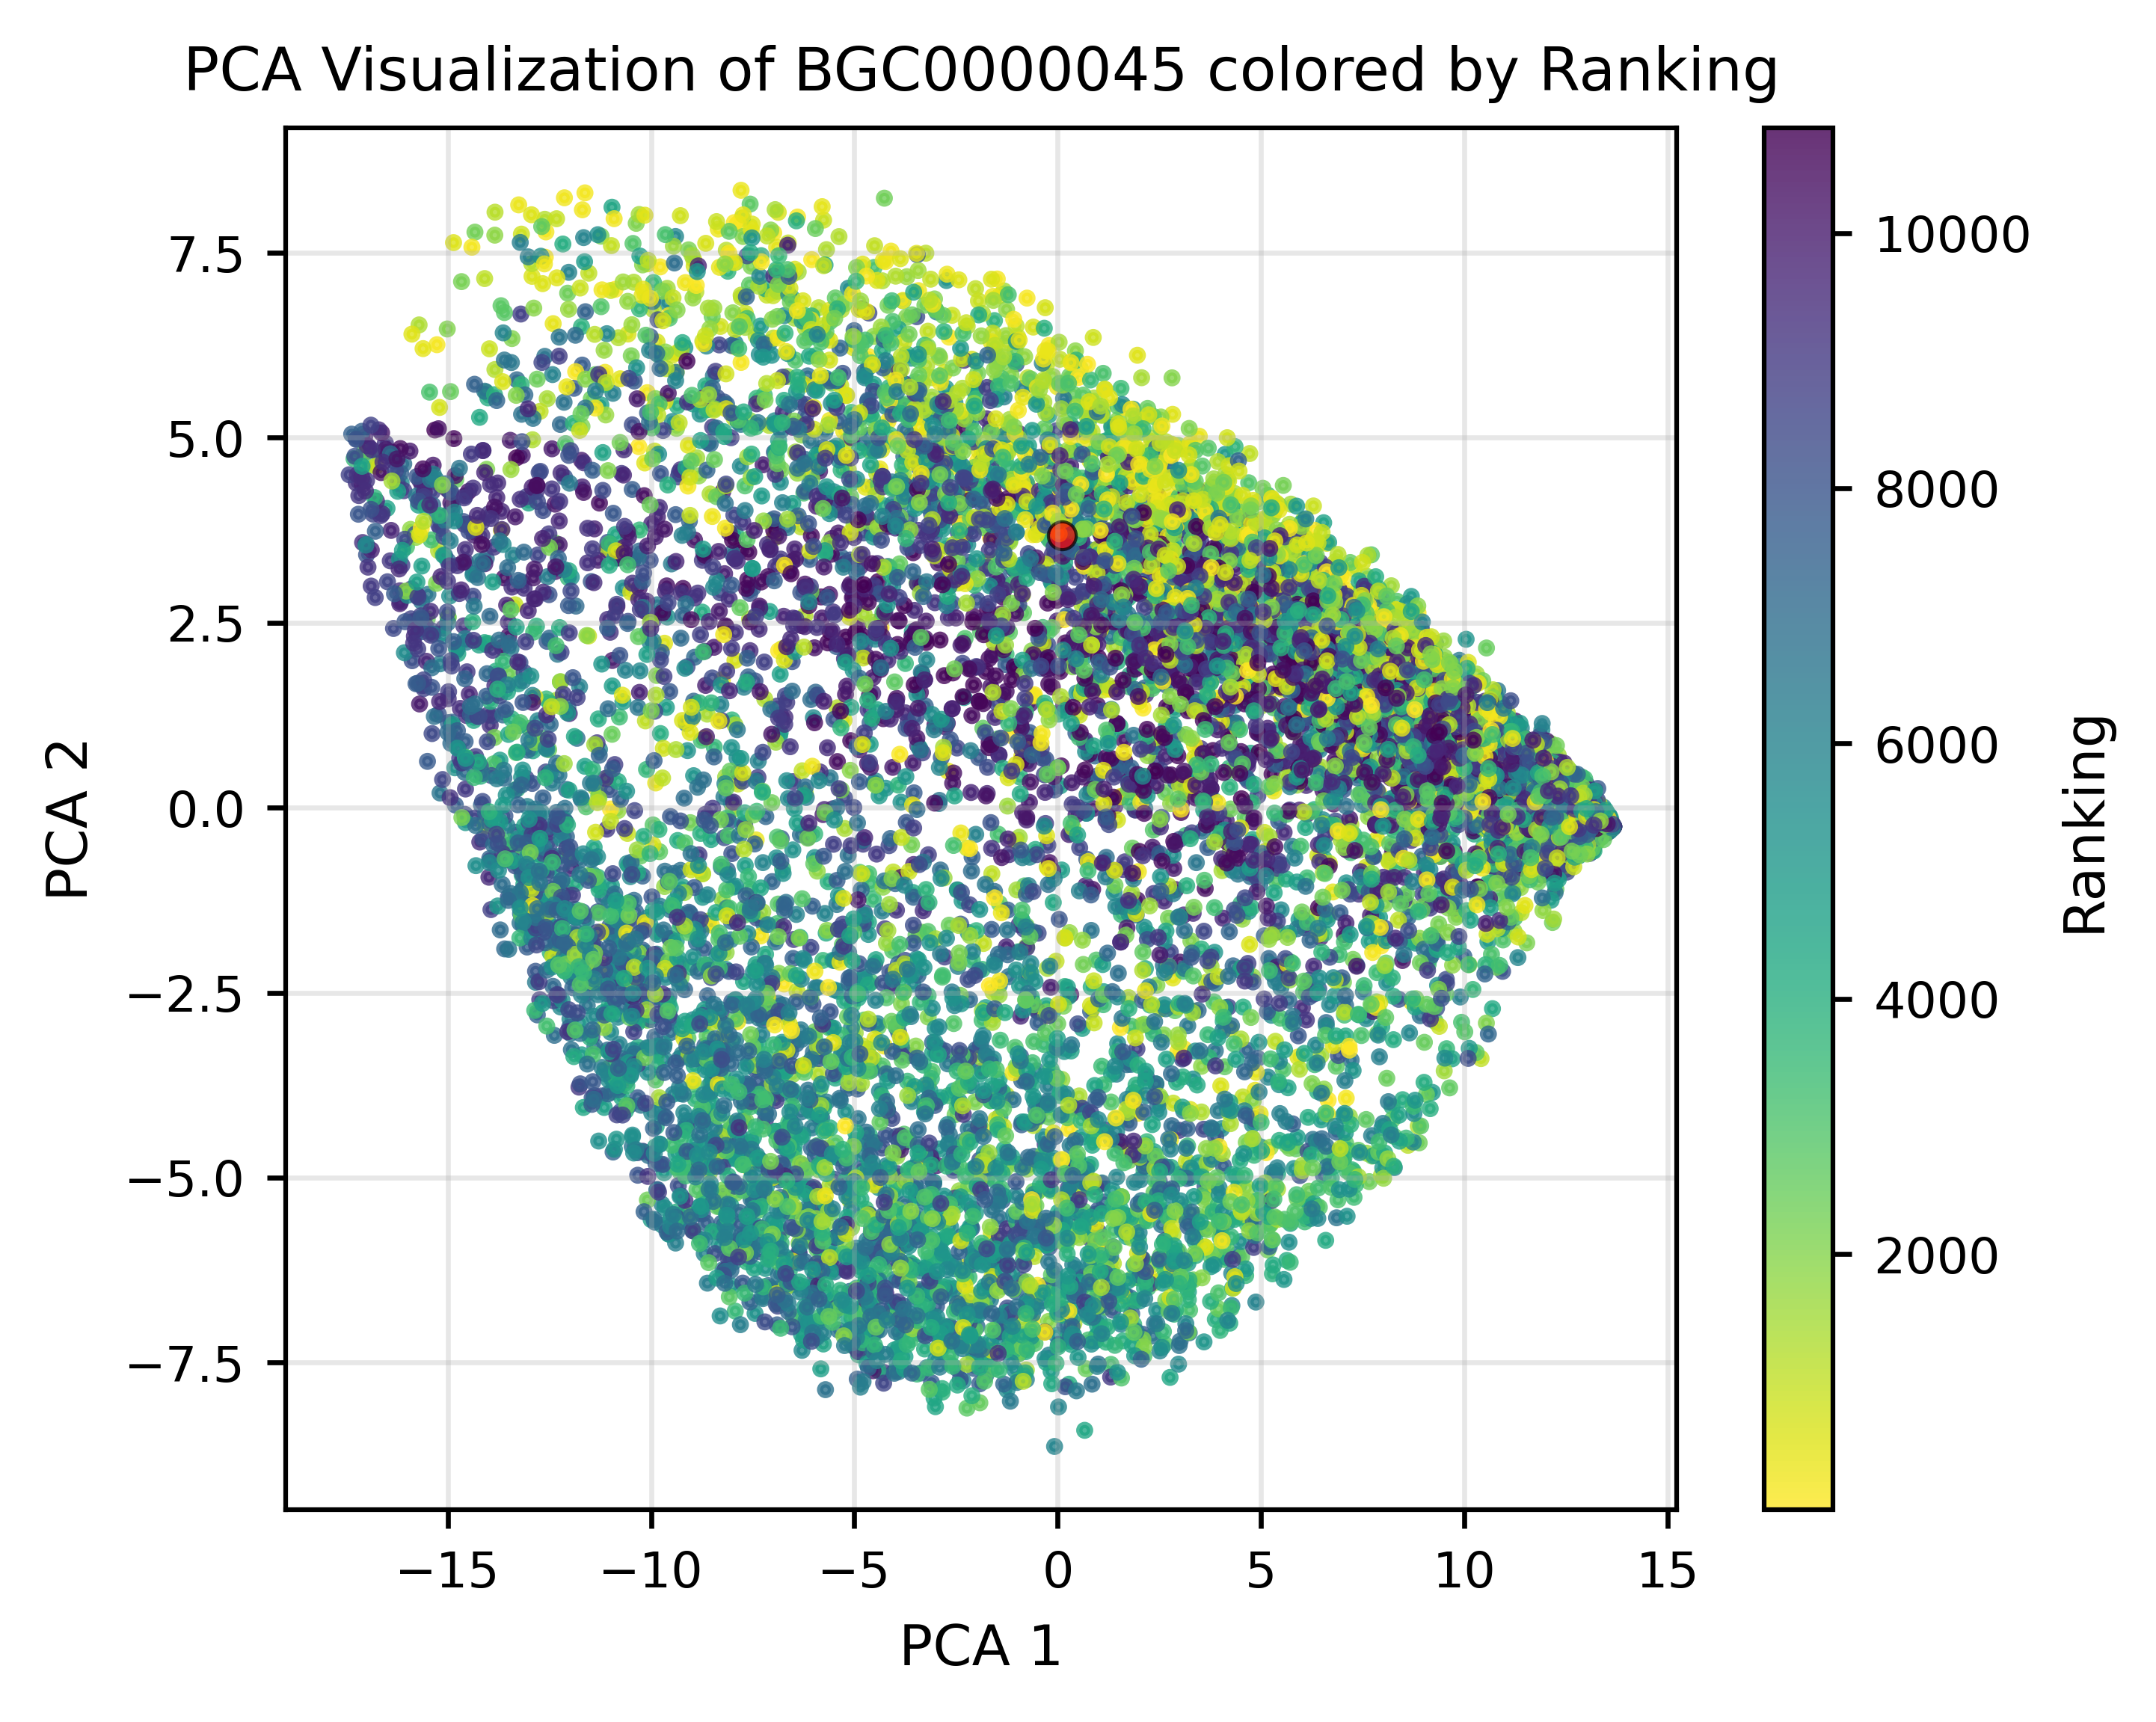

In [ ]:
from sklearn.decomposition import PCA

def pca_pipeline(BGC_product_mapping: dict, BGC_number:str, result_df:pd.DataFrame):
    result_BGC = result_df[result_df["Gbk_file"] == BGC_number]
    product_list = result_BGC["Prospective Product"].tolist()
    target_index = product_list.index(BGC_product_mapping[BGC_number])
    ECFPs = np.array(result_BGC["ECFP"].tolist())
    rank = np.array(result_BGC["ranking"].tolist())

    pca = PCA(n_components=2, random_state=42)
    ECFP_2d = pca.fit_transform(ECFPs)
    
    plt.figure(figsize=(5, 4))
    scatter = plt.scatter(ECFP_2d[:, 0], ECFP_2d[:, 1], c=rank, cmap='viridis_r', s=3, alpha=0.8)

    plt.scatter(ECFP_2d[target_index, 0], ECFP_2d[target_index, 1], 
                    c='red', s=20, alpha=0.7, edgecolors='black', linewidth=0.5) 

    plt.colorbar(scatter, label='Ranking')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title(f'PCA Visualization of {BGC_number} colored by Ranking')
    plt.grid(True, alpha=0.3)
    plt.show()

pca_pipeline(BGC_product_mapping, BGC_number = "BGC0000045", result_df = result_df)

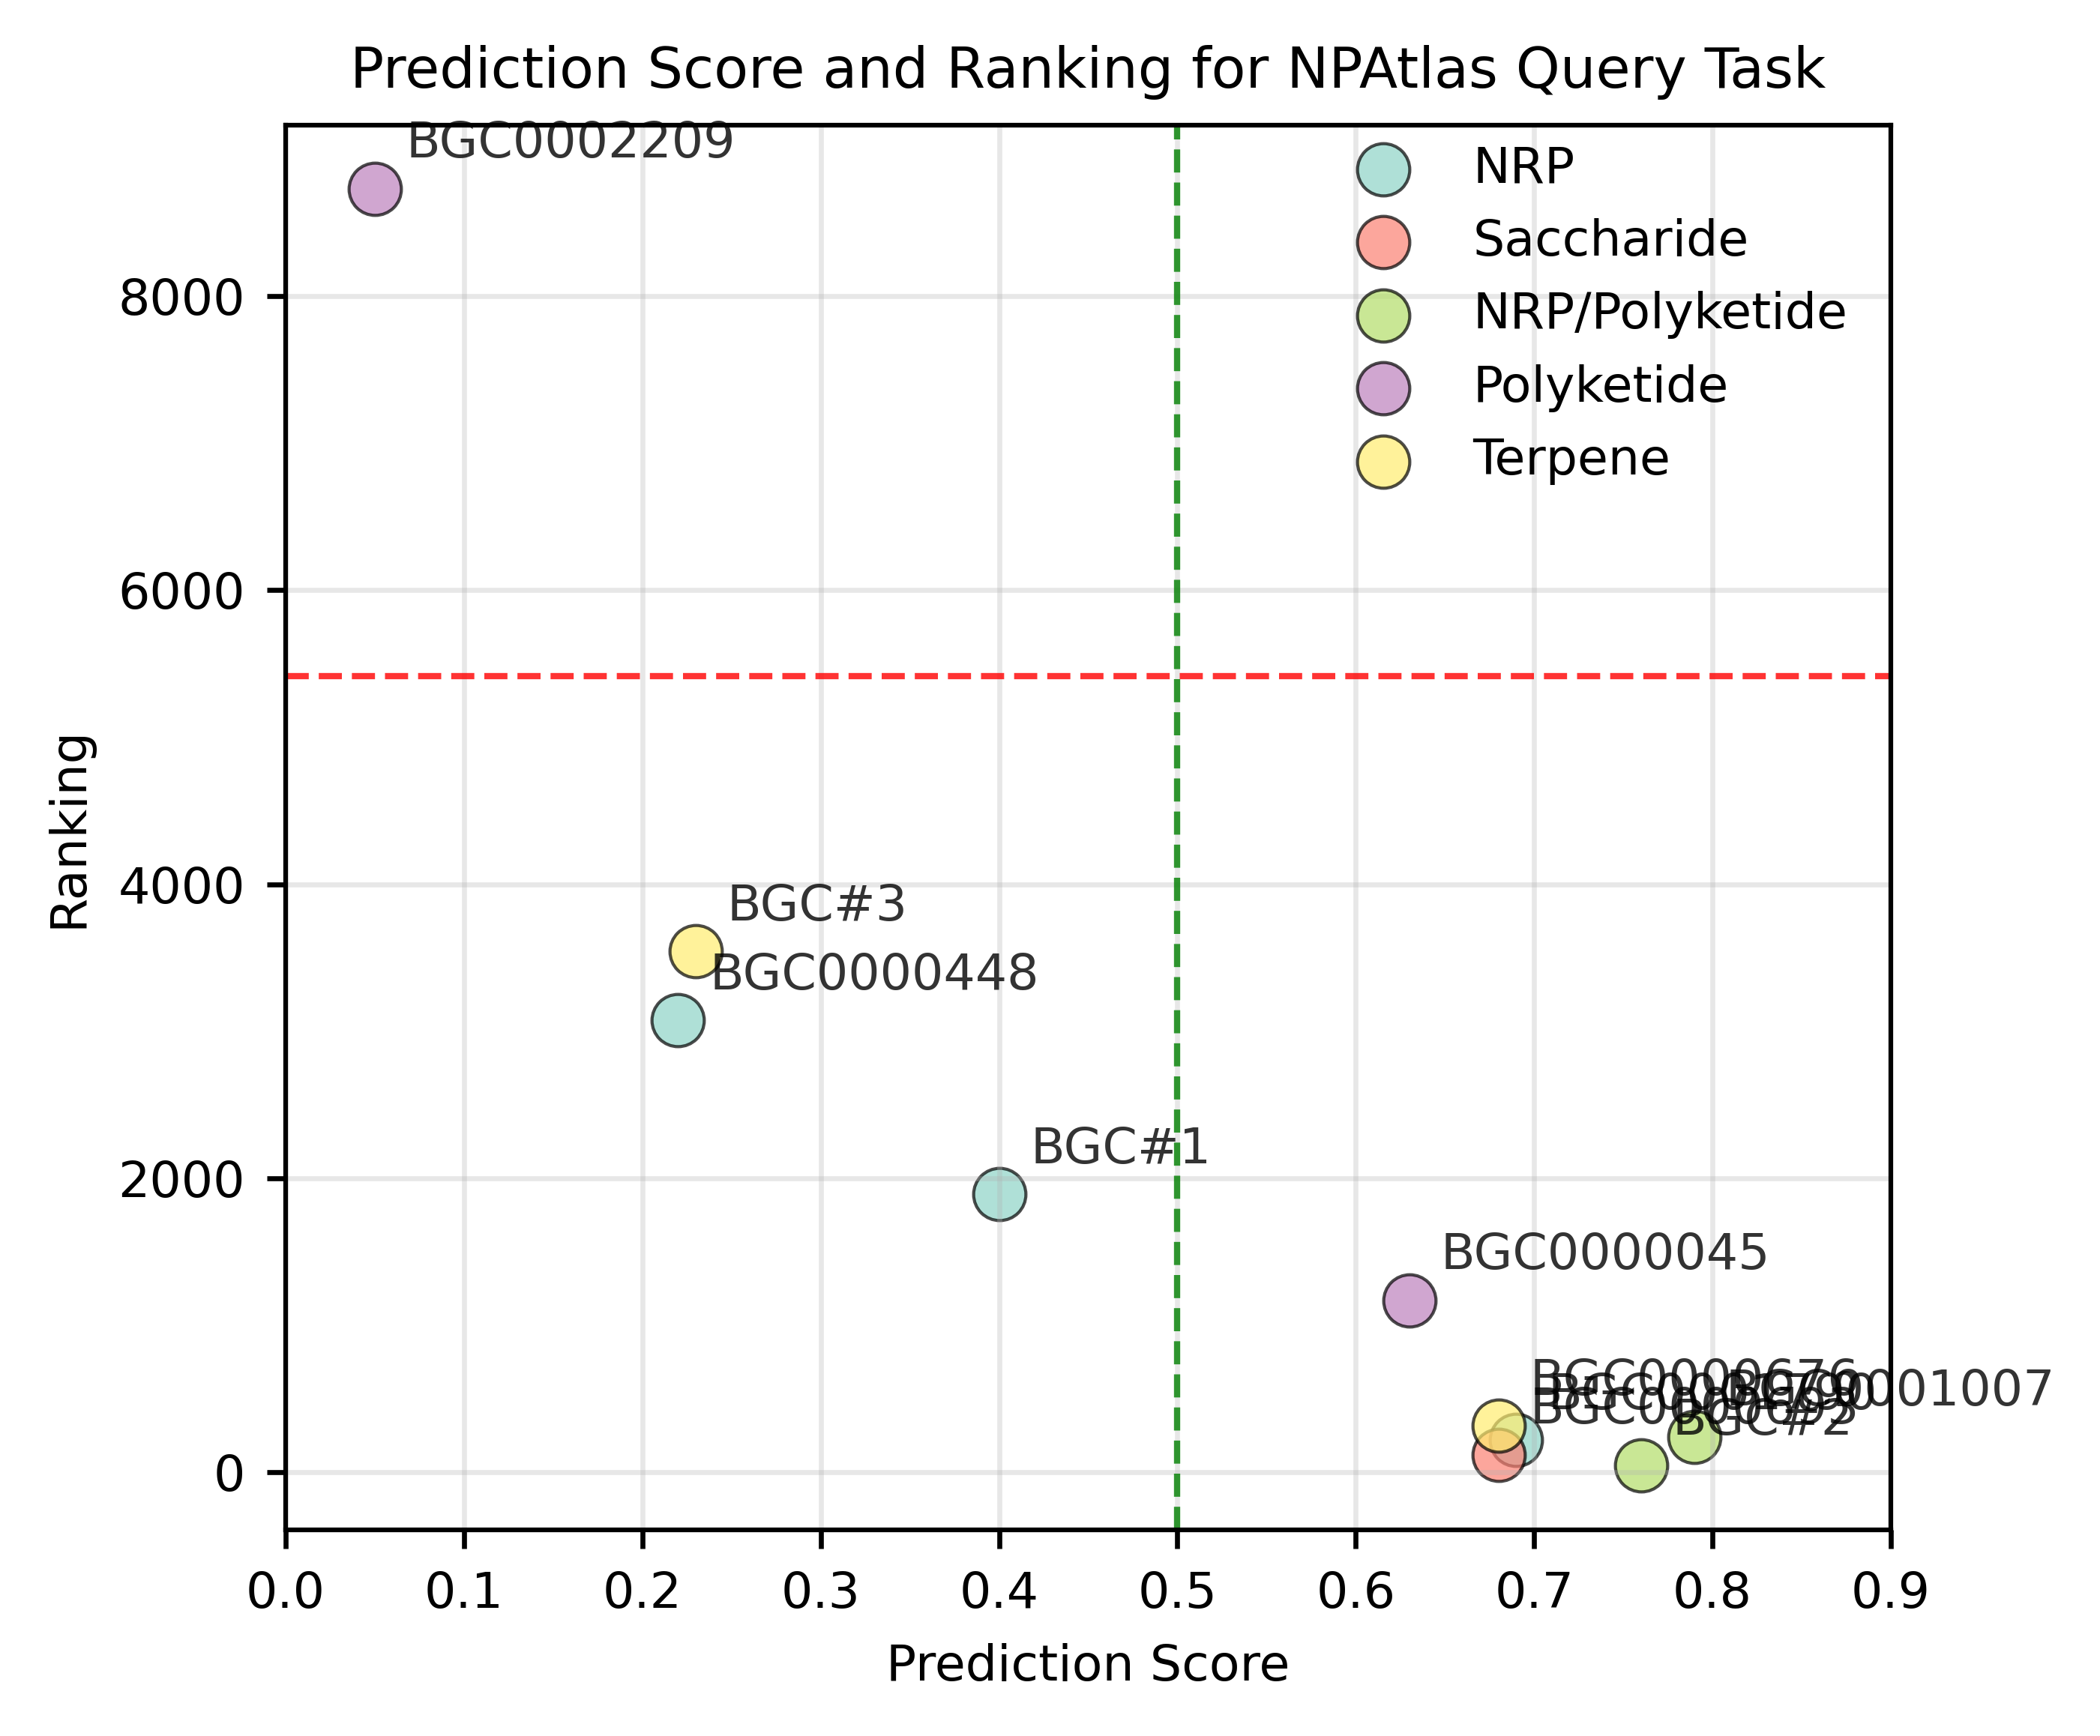

In [ ]:
data = {
    'BGC ID': ['BGC0000448', 'BGC0000693', 'BGC0001007', 'BGC0001790', 'BGC0002209', 
               'BGC0000045', 'BGC0000676', 'BGC#1', 'BGC#2', 'BGC#3'],
    'Class': ['NRP', 'Saccharide', 'NRP/Polyketide', 'NRP', 'Polyketide', 
              'Polyketide', 'Terpene', 'NRP', 'NRP/Polyketide', 'Terpene'],
    'Prediction Score': [0.22, 0.68, 0.79, 0.69, 0.05, 0.63, 0.68, 0.4, 0.76, 0.23],
    'Ranking': [3072, 117, 240, 216, 8730, 1168, 313, 1889, 43, 3542]
}
df = pd.DataFrame(data)

plt.figure(figsize=(4.7, 3.9))
unique_classes = df['Class'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_classes)))
color_dict = dict(zip(unique_classes, colors))

for class_type in unique_classes:
    class_data = df[df['Class'] == class_type]
    plt.scatter(class_data['Prediction Score'], class_data['Ranking'], 
                c=[color_dict[class_type]], label=class_type, alpha=0.7, s=70, edgecolors='black', linewidth=0.5)

for i, row in df.iterrows():
    plt.annotate(row['BGC ID'], 
                (row['Prediction Score'], row['Ranking']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8,
                alpha=0.8)

plt.xlabel('Prediction Score', fontsize=8)
plt.ylabel('Ranking', fontsize=8)
plt.title('Prediction Score and Ranking for NPAtlas Query Task', fontsize=9)
plt.grid(True, alpha=0.3)

plt.axhline(y=5413, color='red', linestyle='--', linewidth=1, alpha=0.8)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=1, alpha=0.8)
plt.xlim(0, 0.9)
plt.legend(bbox_to_anchor=(0.64, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.savefig(os.path.join("..", "visualization", "supporting_figs", f"Prediction_score_ranking_npatlas.pdf"), format='pdf')
plt.show()

## Query MIBiG analysis


In [7]:
MAC_metadata = pd.read_pickle("../data/BGC_4.0/MAC_metadata.pkl")
BGC_class_mapping = MAC_metadata.set_index('BGC_number')['biosyn_class'].to_dict()

In [8]:
mibig_result = pd.read_csv("../output/MAP_BGC#123_MIBiG.csv")
result_df = mibig_result.copy()
result_df = result_df.drop(columns = ["Unnamed: 0"])
result_df["Gbk_file"] = result_df["Gbk_file"].apply(lambda x:os.path.splitext(os.path.basename(x))[0])
result_df

Gbk_file                                Prospective Product  \
0      BGC0001328  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
1      BGC0001328  CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1c1nccs1)N(C)C...   
2      BGC0001328  COc1ccc(/C=C2\OC(=O)[C@H](Cc3cc(Cl)c4c(c3)OCO4...   
3      BGC0001328  C/C=C1\NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@@H]([C...   
4      BGC0001533  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
...           ...                                                ...   
10551          19  C/C=C1\NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@@H]([C...   
10552          49  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
10553          49  CC[C@H](C)[C@@H](C(=O)N1CCC[C@H]1c1nccs1)N(C)C...   
10554          49  COc1ccc(/C=C2\OC(=O)[C@H](Cc3cc(Cl)c4c(c3)OCO4...   
10555          49  C/C=C1\NC(=O)[C@H]([C@@H](C)CC)NC(=O)[C@@H]([C...   

       Probability  
0         0.000459  
1         0.598695  
2         0.000268  
3         0.422982  
4         0.061954  
...            ...  
10551     0.404552  
10552     0.232380  
10553     0.079032  
10554     0.058006  
10555     0.091085  

[10556 rows x 3 columns]

In [ ]:
result_smiles = result_df[result_df["Prospective Product"] == "COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl)[C@]1(O)C[C@@H](O)[C@]2(C)C(=Cc4c5c(cc(Cl)c42)OCO5)[C@@]1(C)[C@H]3O"]
ding_mapping_dict = {
    '19': ["NRPS"], #BGC#1
    '37': ["NRPS", "PKS"], #BGC#2 
    '48': ["other"],
    '49': ["terpene"] #BGC#3
}
BGC_class_mapping.update(ding_mapping_dict)
result_smiles["biosyn_class"] = result_smiles["Gbk_file"].map(BGC_class_mapping)
result_smiles

/tmp/ipykernel_1760051/3266853436.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_smiles["biosyn_class"] = result_smiles["Gbk_file"].map(BGC_class_mapping)


Gbk_file                                Prospective Product  \
0      BGC0001328  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
4      BGC0001533  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
8      BGC0002968  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
12     BGC0000313  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
16     BGC0001066  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
...           ...                                                ...   
10536  BGC0000290  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
10540  BGC0000433  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
10544          48  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
10548          19  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   
10552          49  COC[C@]1(C)[C@H]2[C@H]3OC(=O)[C@]2(CC[C@@H]1Cl...   

       Probability biosyn_class  
0         0.000459  [NRPS, PKS]  
4         0.061954        [PKS]  
8         0.268050  [ribosomal]  
12        0.007089       [NRPS]  
16        0.018101        [PKS]  
...            ...          ...  
10536     0.000505       [NRPS]  
10540     0.000143       [NRPS]  
10544     0.215934      [other]  
10548     0.000628       [NRPS]  
10552     0.232380    [terpene]  

[2639 rows x 4 columns]

In [103]:
from collections import Counter
result_smiles_low = result_smiles[result_smiles["Probability"] < 0.1]
low_class = result_smiles_low["biosyn_class"].to_list()
#low_class =  [x for x in low_class if not (isinstance(x, float) and math.isnan(x))]
low_class = [item for sublist in low_class for item in sublist]
print(Counter(low_class))

Counter({'NRPS': 803, 'PKS': 614, 'ribosomal': 289, 'other': 136, 'saccharide': 106, 'terpene': 6})


In [104]:
result_smiles_high = result_smiles[result_smiles["Probability"] > 0.5]
high_class = result_smiles_high["biosyn_class"].to_list()
high_class =  [x for x in high_class if not (isinstance(x, float) and math.isnan(x))]
high_class = [item for sublist in high_class for item in sublist]
print(Counter(high_class))

Counter({'PKS': 231, 'terpene': 111, 'other': 99, 'saccharide': 35, 'NRPS': 26, 'ribosomal': 11})


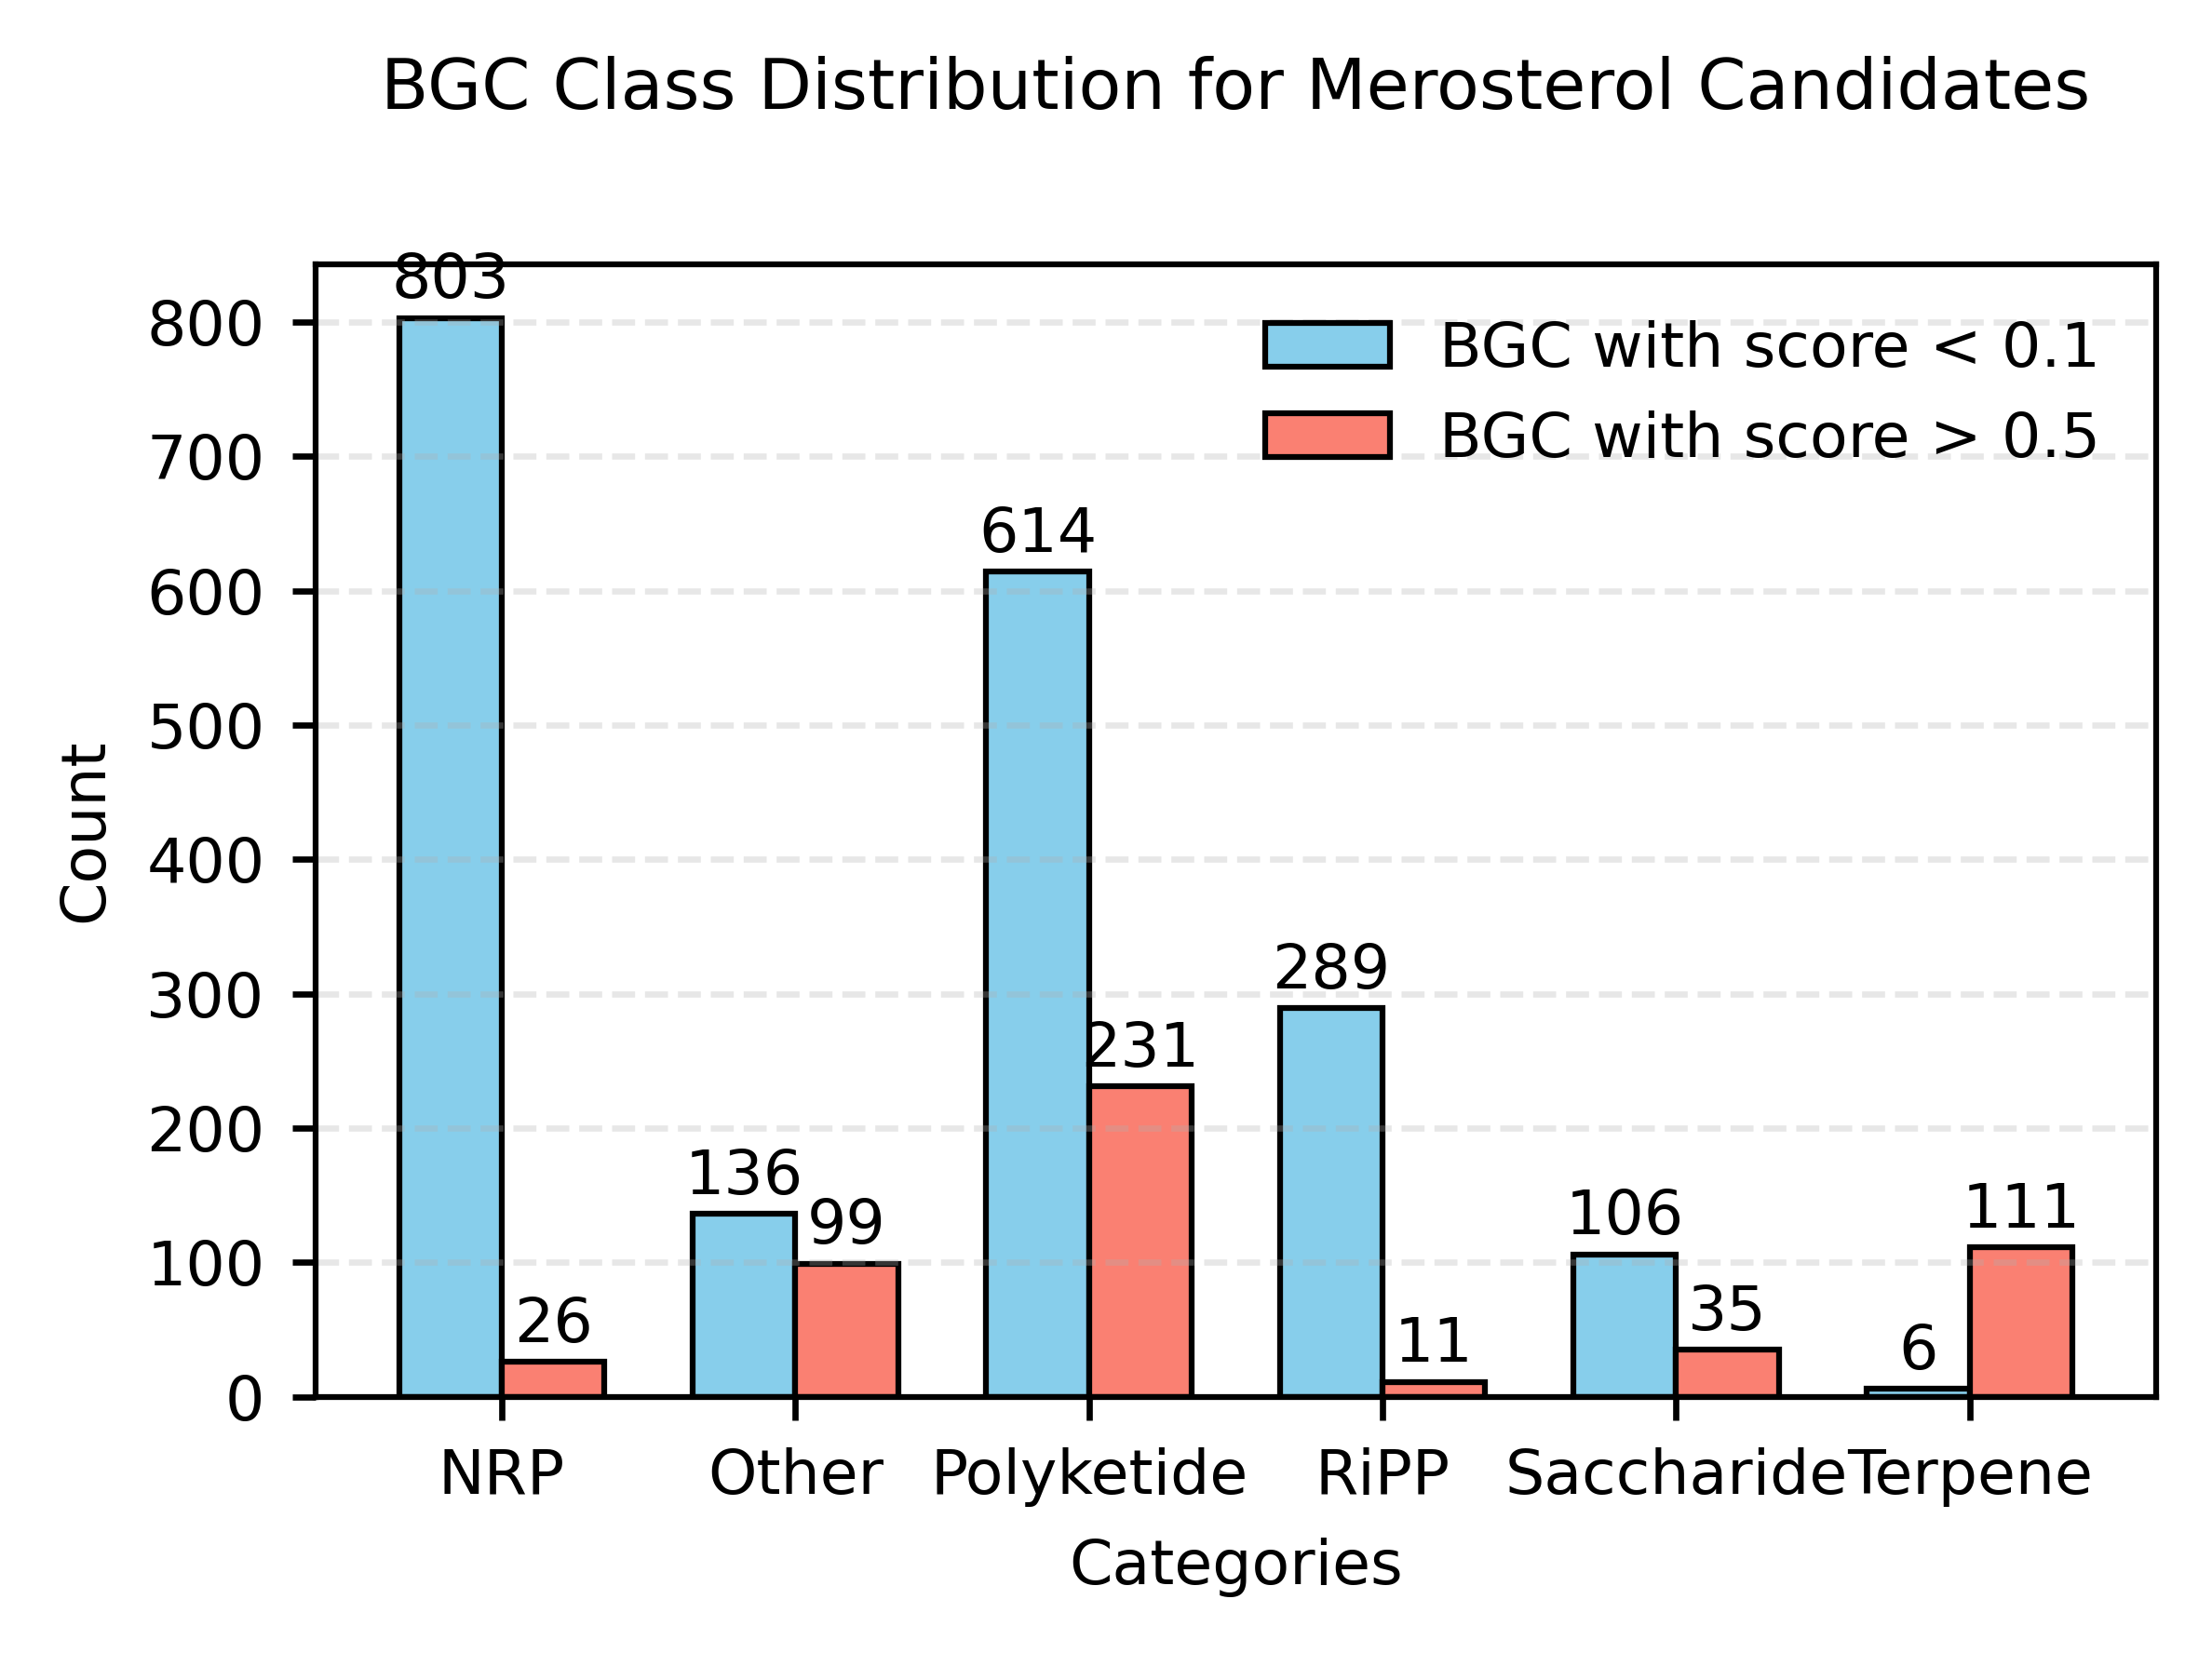

In [115]:
counter1 = Counter({'NRP': 803, 'Polyketide': 614, 'RiPP': 289, 'Other': 136, 'Saccharide': 106, 'Terpene': 6})
counter2 = Counter({'Polyketide': 231, 'Terpene': 111, 'Other': 99, 'Saccharide': 35, 'NRP': 26, 'RiPP': 11})

categories = sorted(set(list(counter1.keys()) + list(counter2.keys())))
n_categories = len(categories)

data1 = [counter1.get(cat, 0) for cat in categories]
data2 = [counter2.get(cat, 0) for cat in categories]

x = np.arange(n_categories)
width = 0.35 # Width of bar
plt.figure(figsize=(4, 3))

bars1 = plt.bar(x - width/2, data1, width, label='BGC with score < 0.1', color='skyblue',  edgecolor='black', linewidth = .75)
bars2 = plt.bar(x + width/2, data2, width, label='BGC with score > 0.5', color='salmon',  edgecolor='black', linewidth = .75)

plt.xlabel('Categories', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.title('BGC Class Distribution for Merosterol Candidates', 
          fontsize=9,  pad=20)

plt.xticks(x, categories, rotation=0, ha='center', size = 8)

def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)

plt.legend(loc='upper right', fontsize=8)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join("..", "visualization", "supporting_figs", "Class_Distribution_Merosterol.pdf"), format='pdf')
plt.show()